In [19]:
import sys
import os
import enum
import random
import pathlib
from optparse import OptionParser

import nilearn
from nilearn import plotting
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.vgg import vgg11_bn
from torch.autograd import Function, Variable
from torch.utils.data import DataLoader, Subset
from torch.nn.modules.loss import CrossEntropyLoss
import torch.backends.cudnn as cudnn
from torch import optim

from torchio import AFFINE, DATA, PATH, TYPE, STEM
from torchio import transforms
import torchio as tio

from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from scipy.spatial.distance import directed_hausdorff

import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time
import warnings
import multiprocessing
from tqdm.notebook import tqdm
%matplotlib inline
import wandb

In [20]:
# !pip install --quiet --upgrade unet 
from unet import UNet

In [2]:
# os.environ["WANDB_API_KEY"] 

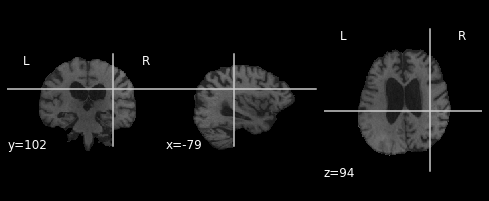

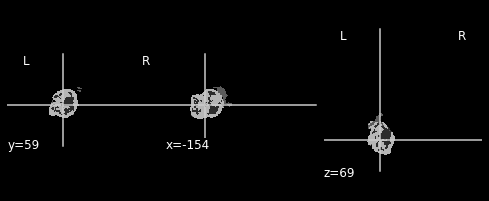

In [3]:
# visualising normalised image
img = nilearn.image.load_img('/data/brats/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01265/BraTS2021_01265_t1.nii.gz')
plotting.plot_anat(img)
# visualising segmentation
img = nilearn.image.load_img('/data/brats/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01265/BraTS2021_01265_seg.nii.gz')
plotting.plot_anat(img)

In [12]:
path_to_train = pathlib.Path('/data/brats/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/')
path_to_val = pathlib.Path('/data/brats/RSNA_ASNR_MICCAI_BraTS2021_ValidationData')

In [13]:
"""
    Code addata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAekAAADJCAYAAAAHFcoVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/Il7ecAAAACXBIWXMAAAsTAAALEwEAmpwYAAATIUlEQVR4nO3df2jU9QPH8ddyMlPP5jR/ZBZelkJON+inRUvsDxsaZqXWIoiIwsBgxMxKHQQmy0wLNc2arrbCFExh0yDKYUYZ/dCKhnJTsXRLt+Gl+GPz8/3j2+e63e5un9vu9nnf554PeLP78fnc533szft17/fnV5YkSwAAwDhXuV0BAAAQHSENAIChCGkAAAxFSAMAYChCGgAAQxHSAAAYipAGAMBQhDQAAIYipAEAMBQhDQCAoQhpAAAMRUgDAGAoQhoAAEMR0gAAGIqQBgDAUIQ0AACGIqQBADAUIQ0AgKEIaQAADEVIAwBgKEIaAABDEdIAABiKkAYAwFCENAAAhiKkAQAwFCENAIChCGkAAAxFSANABigtLVVpaanb1UCCst2uAAAg9SZMmOB2FdADjKQBADAUIQ0ASdTY2Kjp06e7XQ0kWWNjo86fP69gMKiTJ0+qsrJSgwYNSvl2CWkAAByYNWuWfD6fCgoKVFhYqMWLF6d8m4Q0AAAJaGpq0p49e1RQUJDybRHSAAAkYMyYMXrwwQd15MiRlG+LkAYAwIEdO3bo7NmzOnHihJqbm7Vs2bKUb5OQBgDAgdmzZ2vIkCEqKirSxIkTNXz48JRvk5AGACAB9fX12rx5s1auXJnybXExEwBIsv79+ysnJyf0vL29XR0dHS7WCMm2evVqHT16VJMnT9bBgwdTth1G0gCQZHV1dbpw4UKolJeXu10lJNnp06dVVVWlpUuXpnQ7jKQBIInGjRvndhWQAtH+rwsWLEj5dhlJAwBgKEIaAABDEdIAABiKkAYAwFCENAAAhiKkAQAwFCENAIChCGkAAAxFSAMAYChCGgAAQxHSAAAYipAGAMBQGRvSpaWlKi0tdbsaSDO0GwB9KWPvgjVhwgS3q4A0RLsB0JcydiQNAIDpUh7SjY2Nmj59eqo3Axc0Njbq/PnzCgaDOnnypCorKzVo0CC3qwUAnsFIGr0ya9Ys+Xw+FRQUqLCwUIsXL3a7SgDgGYQ0kqKpqUl79uxRQUGB21UBAM8gpJEUY8aM0YMPPqgjR464XRUA8AxCGr2yY8cOnT17VidOnFBzc7OWLVvmdpUAwDMIafTK7NmzNWTIEBUVFWnixIkaPny421UCAM8gpJEU9fX12rx5s1auXOl2VQDAM/rkYib9+/dXTk5O6Hl7e7s6Ojr6YtPoQ6tXr9bRo0c1efJkHTx40O3qAEDa65ORdF1dnS5cuBAq5eXlfbFZ9LHTp0+rqqpKS5cudbsqAOAJKR9Jjxs3LtWbgEui/W8XLFjgQk0AwJvYJw0AgKEIaQAADEVIAwBgKEIaAABDEdIAABiKkAYAwFCENAAAhiKkAQAwFCENAIChCGkAAAxFSAMAYChCGgAAQxHSAAAYipAGAMBQhDQAAIYipAEAMBQhDQCAoQhpAAAMRUgDAGAoQhoAAEMR0kAfKikpcbsKANJIttsVSEfhHW11dbWLNYGJugvikpIS2g0ARwjpHqiurg51xPZfOl3YIttCtNCm3QBwImNDesSIERo5cqRqa2tjLlNcXBzzPTrXzBav3Ujx2044RtUA4sm4kLY719zcXMfLRna4kSMjOtnMkp+fr7a2trjLxGo7AJCIjAjp7kY9Tte3O1w7lDkIKPPk5+d3el5WVtbpeUVFRafndtuJ90OO0TSAWDIipBMR3ulGdriR6Fgzi5Mfe4m0HwDojqdPwaqtre3SsZaVlXUZ/YQL71gjl+vtiBzpK9b/3mkQl5SUMPMCIGGeDelonWq8cA4Xr+MlqL3N/mFn/5+j/dBzyml7k9h1AiA6T053251qrKlHJ6OfioqKhDpZpKd4ARxtFmbjxo1dlrPbipN2Fe/UK/ZNA4jkyZCWuo5inHaiQCypbj8ENIBIngvpaCMju3ONF9SxRs326wS890TOuPTkf9zTdcMviGM/B4BIngvp4uJi1dbWRu00Y01LMq0NiR9kAMzj2QPHYqEDRqSKiopQkfrmR1v4jA+jaACxeC6kS0pKVFxc7PhKT0465FgXqIB32KfmRQa101P2wpd3sq1wHNkNIBbPhXQ4prGRqO6uINbduoksTzgD6I6nQtru9OxzW6N1mPbIKBAIKBAIOPpcwj4zxDpNL7IdBQKBLiPn8OnyWJzs8ya4AYTz1IFjTjo4u4PMzc11HNLsx84MifwYi3bwYbx2Eh7q0ZYLb7sc9Q3AliXJivXmhg0b+rAqvWff/MAOX7/fH3W5QCCgG264QZJ0/Pjxbj831uccOnSoJ9WEISJvlhEIBGL+r23t7e2S/t9u7GW7a2+RmpqaQo+bm5tDj0eMGNFl2fD30XsNDQ1atWqV29Vwhd2fP/fccy7XBInwzHR3eED7/X7HHSYQzulukGjty+nMzMiRI6O+TiADiBR3ujudfnHZR1zn5eV1uddv5BRjXl6esrOzQ48jRZv2DF+fewR7Q/hR+pH7i2PdL9reTRLebvLy8mK2mViXps3JyVF1dTWXBwUQlydG0pGdbbTTZ6J1orFGPuyD9r7enEbndJamu33csY6hIKAB2Dx14Fh3I+BIfr9fbW1tnUZRHMmdWexZlsjznZP9Qy3y85iNAeCEJ0bStt5ceznycSx0rpmlJxcnAYBk8dRIWur+ClCJ3qaS0bX3dXdzFQBwi6dG0pGcBnKkyClP+y+jaO/o7n+ZzIBmqhtAT3luJG2LDFip6/WZu1s3HB2rN8W6I1qy9klzECKA3vBsSDsRCAS0YsWK0HM6VNic/JjryWibH3twi32xHE7xSy8ZFdLh+6tffvll+f1+R/ucadCZI9Y9x3u7LOEMkxDU6SPuZUHTTeS5r3bHGO2c2NzcXEmxL1oRvj68qaSkJOEbWjhpN9HQluCmkpISPfroo5Kkbdu2SWLwkS48FdLdCQ/reJ0tHWrmSDSoEw1p2hLcFN627ZB++OGH3aoOeiCjprvDO8z9+/d3uwy8z740Z0+uQBbeVsLXpw3BVFwfPv1kVEiHs+9glU7XJ0fqxArcyGVi3UmIYAaQChkb0kAsBC68INHjLWAmT1/MBACAdMZIGgDSXPgumnhHbefn5/dFdZBEhDQAeER4QIdPd0e+br/Hrh3zMd0NAGmqpKREtbW1obMUwl+3lZWV6ZdffpEkNTU1SfovtHtzX3X0DUIaANJUIgeHnTt3TiNHjuyyDkFtNqa7ASBNRe5/jhxB2yoqKkIX4glf116+traWqW9DEdIAkOYiR8eRAR3rvfD1Jk2apF9//TVFNURPMd0NAGks2pR3tFv1Rr4ndQ3zSZMmpaCG6A1CGgDSXLTTruLdnS0yqMPDmqA2CyENAGmqurpaxcXFXULayb3O402DwxyENABkoFihPGXKFEbTBiGkASDNhZ9GZYdv5DR2uHijZvucaoLaDBzdDQAeEe+o7kTZ63NqlrsIaQDwkHjhHAgEtGLFij6sDXqL6W4A8Ijejp5hHkIaANKYk8t6lpWVKRAIpOzzkTqENACkqXgBmsxTqghq9xDSAOBxFRUV8vv9CS0PM3DgGJCA5557zu0qAMggWZIstyvhhg0bNkii0wXwH7tfSBf5+fmOl21vb5ckHT9+PDSqtvdT+/3+Tvuso426Dx061JuqIo54OdQn092VlZW6ePGigsFgqFx11X+bfuaZZ3T48GEFg0HV1dVp9OjRfVEtZJhRo0bp888/159//inLsnTjjTd2er+7dmpbsmSJLMvS9OnT+6rqQFIMGDCgUwD7/f6EpsHR9/psuruiokJLlizp8npRUZGWL1+uadOm6fDhw1qzZo0++eQT3X///X1VNWSIK1euaPfu3XrjjTf07bffRl0mVju1+f1+PfbYY/rrr79SVU24KJ1m1mpra9XW1uZo2bKyMm3cuFHt7e1qa2vr9qCyyH3SXNDEPd2OpF966SVt27at02tr1qzR6tWrk1KBmTNn6rPPPtPvv/+uy5cv6/XXX1dRURG/7jKc3+/XmTNnVFhYKEkaPXq0mpubVVRU1OPPbG5u1vr163XgwIEef8batWu1aNEiXbp0qcefASSD0+AsKyvrEroVFRVxDw7jZhvm6DakP/74Y82YMUPXXHONJKlfv36aP3++qqqqtHbtWrW2tkYt9vVfbQsWLNCZM2f0ww8/aM6cOZ3ey8rK6vKY68ZmtkAgoEWLFunjjz/W1VdfrcrKSm3ZskV79+5NqN0lKl47ffTRR3Xx4kXV1dX1ahtAXyFs01+3IX3q1CnV19frsccekyTNmDFDp0+f1o8//qgXXnhBQ4cOjVqmTJkS+ox33nlHN998s0aMGKElS5Zo8+bNmjp1qiRp9+7dmjt3rvLz8zVgwAAtXbpUV65c0cCBA1P0lZEuNm3apCNHjui7777T6NGj9eqrr0qS43aXqHjtdPDgwVq+fLlefPHFpHw3INmi3VO6JyJH2Ux1u8vRgWNbtmzRk08+KUl68skn9dFHHyW0kZ9++kktLS3q6OhQXV2dqqurQ6OUL7/8UsuWLdP27dt19OhRHT16VMFgUCdOnEjwq8CL3n//feXn5+vdd99NaIr53nvvDR389euvvzpaJ147LS8v10cffaRjx4716HsAqVBcXBy6n3RPQjoykDk/2jyOQnrHjh2aPHmybr31Vs2cOTPUGNavX9/pSNjwEq9jtCyr0xT3unXrdMstt2jUqFHavn27srOzHXesPdXQ0KCGhoaUbgO9M2jQIK1evVqbNm1SeXm5hg4dKslZu9u3b598Pp98Pl+Pd52Et9Pp06dr4cKFOnnypE6ePKmxY8dq69atTCfCCMkaRUdiFO0+x+dJb9y4UXfeeadOnz6d8KknjzzyiHbv3q3z58/rgQce0Pbt2zVr1izt3btXOTk5Gj9+vH777TeNHTtWVVVV2r9/f2hqE5lr06ZNGjx4sObPn68NGzYoNzdX8+bN69Vn5uTkqF+/fjp37pwmTJigY8eO6eLFi5Lit9O8vDz1798/9DkHDhxQaWmp6urqdO7cuV7VCUiWeJfvzM3NDd0FK3zEHO/2loS0+xyfgrVlyxY9++yzevrppxPeyIsvvqgPPvhAWVlZamxs1LPPPqu9e/dK+v95ezU1NbrpppsUDAZVWVkZ9xQYZIaHHnpIM2bMCF2sobS0VD///LOeeOIJ1dTU9PhzL1y4EHpsz6TYo+V47bSlpaXT53R0dKi1tZWAhmcQ0GZyPJIeO3as/vjjD40aNUrBYDDF1QIA9FTkiLqsrEwvv/yyJHW6n3S8fdCEtBkc7ZPOyspSaWmpPv30UwIaANKU3+/v9hxpmKXbkfTAgQPV1NSkY8eOacaMGRx1DQBpIHI0nZubK0mOr1LGSNoM3e6TPn/+vHw+X1/UBQCQJOEhy/2g0xf3kwYAjysuLk7oLlaMos3B/aQBIEMcOnSo001EwkfYBLOZCGkAyFAEs/mY7gYAwFCENAAAhiKkAQAwFCENAIChCGkAAAxFSAMAYChCGgAAQxHSAAAYipAGAMBQhDQAAIYipAEAMBQhDQCAoQhpAEiiwsJC7d27V8FgUKdOndLChQtD791999367rvvdPbsWf3yyy+65557XKwp0gEhDQBJMmzYMO3evVsbNmzQsGHDNH78eH3xxReSpKFDh2rXrl168803lZubq4qKCu3atUu5ubnuVhpGI6QB4F9z585VMBgMlQsXLuirr75yvH5paan27NmjmpoaXbp0Sf/884/++OMPSdLUqVN16tQpbdu2TVeuXFF1dbX+/vtvzZkzJ1VfBx5ASAPAv7Zu3Sqfzyefz6frrrtOgUBAn3zyiRYtWqTW1taYxXbXXXeppaVF33zzjZqamrRz506NHTs29H5WVlan7WVlZWnSpEl98t0aGhrU0NDQJ9tCclkUCoVC+a9kZWVZu3btstatW5fQeg0NDVZra6t12223WTk5OdaaNWusffv2WZKsvLw8q7W11Zo/f76VnZ1tPfXUU1ZHR4f13nvvuf59KUYX1ytAoVAoRpXly5dbX3/9tZWdnZ3Qej///LP14Ycfhp7n5eVZlmVZQ4YMsSRZ9913n/X9999bZ86csWpqaqw9e/ZYr732muvfl2JuyRYAIGTevHl6/PHHdfvtt6u9vV2StHjxYr3yyisx1/H5fJKkgwcPyrKs0OvhjyWpvr5ed9xxhySpX79+CgQCeuutt5L9FeAxrv9SoFAoFBNKQUGB1dzcbE2ZMqVH60+bNs1qaWmxpkyZYmVnZ1urVq2y6uvrO31+dna25fP5rLfffjs0FU6hxCmuV4BCoVCMKMuWLbMuX75sBYPBUKmtrU3oM55//nnrxIkTVktLi7Vz507r+uuvD71XU1NjtbW1WW1tbdann35qXXvtta5/Z4rZJevfBwAAwDCcggUAgKEIaQAADEVIAwBgKEIaAABDEdIAABiKkAYAwFCENAAAhiKkAQAwFCENAIChCGkAAAxFSAMAYChCGgAAQxHSAAAYipAGAMBQhDQAAIYipAEAMBQhDQCAoQhpAAAMRUgDAGAoQhoAAEMR0gAAGIqQBgDAUIQ0AACG+h+Gc60igGisRwAAAABJRU5ErkJggg==apted from: https://github.com/fepegar/torchio#credits

        Credit: Pérez-García et al., 2020, TorchIO: 
        a Python library for efficient loading, preprocessing, 
        augmentation and patch-based sampling of medical images in deep learning.

"""

CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4
MRI_t1ce = 'MRI_t1ce'
MRI_flair = 'MRI_flair'
LABEL = 'LABEL'
SUB = 'SUB'

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def get_torchio_dataset(path, transform, mode='t1'):
    """
    The function creates dataset from the list of files from cunstumised dataloader.
    """
    subjects = []
    sub_list=sorted(os.listdir(path))
    for s in tqdm(sub_list):
        image_path_t1ce=os.path.join(path,s,s+ '_'+ 't1ce' +'.nii.gz')
        image_path_flair=os.path.join(path,s,s+ '_'+ 'flair' +'.nii.gz')
        if 'Training' in str(path):
            label_path=os.path.join(path,s,s+ '_seg.nii.gz')
            
            subject_dict = {
                MRI_t1ce : torchio.Image(image_path_t1ce, torchio.INTENSITY),
                MRI_flair : torchio.Image(image_path_flair, torchio.INTENSITY),
                LABEL: torchio.Image(label_path, torchio.LABEL),
                SUB: image_path_t1ce
            }
        elif 'Validation' in str(path):
            
            subject_dict = {
                MRI_t1ce : torchio.Image(image_path_t1ce, torchio.INTENSITY),
                MRI_flair : torchio.Image(image_path_flair, torchio.INTENSITY),
                SUB: image_path_t1ce
            }
        subject = torchio.Subject(subject_dict)
        subjects.append(subject)
    
    if transform:
        dataset = torchio.SubjectsDataset(subjects, transform = transform)
    elif not transform:
        dataset = torchio.SubjectsDataset(subjects)
    
    return dataset, subjects

In [14]:
data, subjects = get_torchio_dataset(path_to_train, False)
testing_data, testing_subjects = get_torchio_dataset(path_to_val, False)

  0%|          | 0/1251 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

In [16]:
def plot_central_cuts(img, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])
    
    plt.show()
    
def plot_predicted(img, seg, delta = 0, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if (len(img.shape) == 5):
            img = img[0,0,:,:,:]
        elif (len(img.shape) == 4):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
        
    if isinstance(seg, torch.Tensor):
        seg= seg[0].cpu().numpy().astype(np.uint8)
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2 + delta, :, :])
    axes[1].imshow(seg[ seg.shape[0] // 2 + delta, :, :])
    intersect = img[ img.shape[0] // 2 + delta, :, :] + seg[ seg.shape[0] // 2 + delta, :, :]*100
    axes[2].imshow(intersect, cmap='gray')
    
    plt.show()

Dataset size: 1251
Image shape: (1, 240, 240, 155)
Segmentation shape: (1, 240, 240, 155)


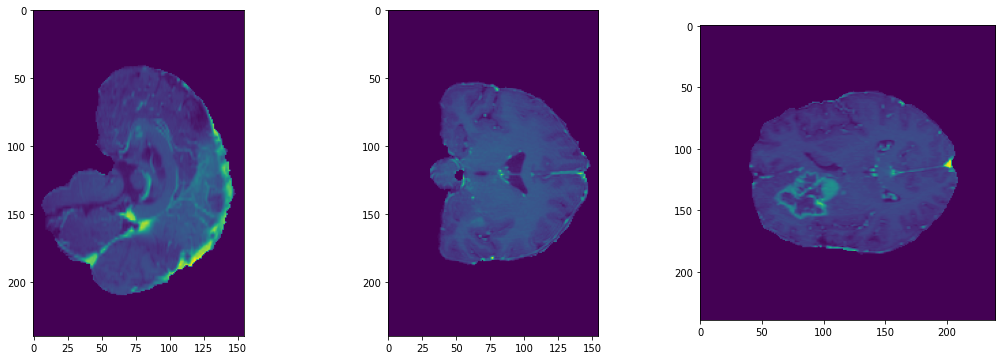

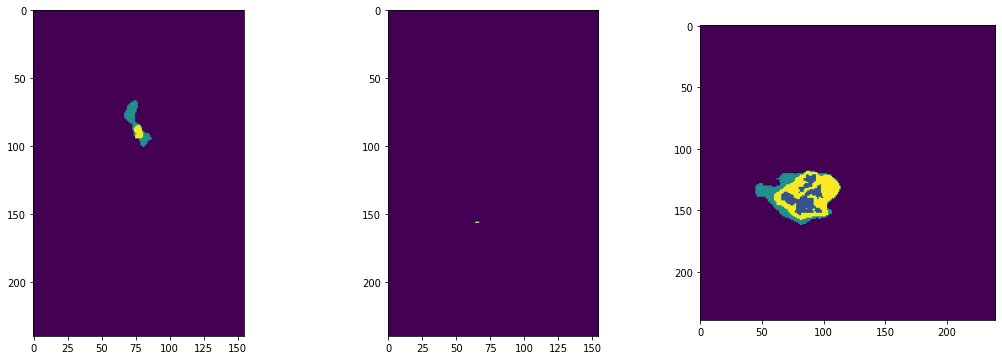

In [18]:
print("Dataset size: {}".format(len(data)))
img = data[0][MRI_t1ce]
seg = data[0][LABEL]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img[DATA])
plot_central_cuts(seg[DATA])

In [21]:
num_subjects = len(data)

training_split_ratio = 0.7

get_foreground = tio.ZNormalization.mean
LI_LANDMARKS = "0 8.06305571158 15.5085721044 18.7007018006 21.5032879029 26.1413278906 29.9862059045 33.8384058795 38.1891334787 40.7217966068 44.0109152758 58.3906435207 100.0"
LI_LANDMARKS = np.array([float(n) for n in LI_LANDMARKS.split()])
landmarks_dict = {'MRI_t1': LI_LANDMARKS, 'MRI_lite' : LI_LANDMARKS, 'MRI_zyx': LI_LANDMARKS, 'MRI_t1ce': LI_LANDMARKS,
                  'MRI_t2': LI_LANDMARKS, 'MRI_flair': LI_LANDMARKS}

train_transform = tio.Compose([     # to MNI space (which is RAS+)
    tio.RandomAnisotropy(p=0.25),              # make images look anisotropic 25% of times
#     tio.CropOrPad((180, 220, 170)),            # tight crop around brain
    tio.HistogramStandardization(
        landmarks_dict,
        masking_method=get_foreground),        # standardize histogram of foreground
#     tio.ZNormalization(
#         masking_method=get_foreground),        # zero mean, unit variance of foreground
    tio.RandomBlur(p=0.25),                    # blur 25% of times
    tio.RandomNoise(p=0.25),                   # Gaussian noise 25% of times
#     tio.OneOf({                                # either
#         tio.RandomAffine(): 0.8,               # random affine
#         tio.RandomElasticDeformation(): 0.2,   # or random elastic deformation
#     }, p=0.8),                                 # applied to 80% of images
    tio.RandomBiasField(p=0.3),                # magnetic field inhomogeneity 30% of times
#     tio.OneOf({                                # either
#         tio.RandomMotion(): 1,                 # random motion artifact
#         tio.RandomSpike(): 2,                  # or spikes
#         tio.RandomGhosting(): 2,               # or ghosts
#     }, p=0.5),                                 # applied to 50% of images
])
        # apply the transf
validation_transform = tio.Compose([                  # to MNI space (which is RAS+)
    tio.HistogramStandardization(landmarks_dict, masking_method=get_foreground),  # standard histogram
#     tio.ZNormalization(masking_method=get_foreground),                            # zero mean and unit std
])
training_subjects, validation_subjects = train_test_split(
    subjects, train_size=training_split_ratio, shuffle=False, random_state=42
)

training_set = torchio.SubjectsDataset(
    training_subjects, transform=train_transform)

validation_set = torchio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

testing_set = torchio.SubjectsDataset(
    testing_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')
print('Testing set:', len(testing_set), 'subjects')

Training set: 875 subjects
Validation set: 376 subjects
Testing set: 219 subjects


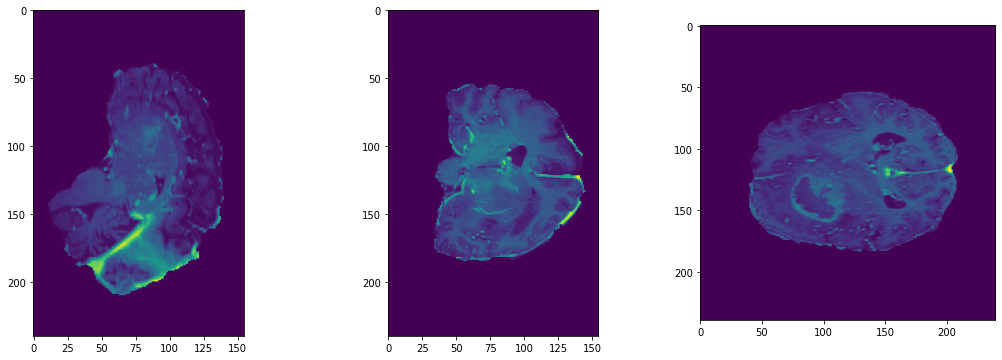

In [22]:
plot_central_cuts(training_set[1][MRI_t1ce][DATA])

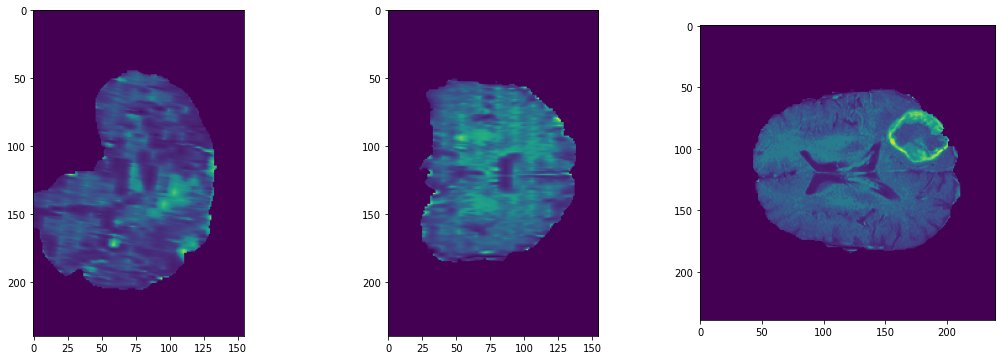

In [23]:
plot_central_cuts(validation_set[1][MRI_t1ce][DATA])

In [25]:
!nvidia-smi


Tue Aug 31 14:27:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   35C    P0    35W / 250W |  15985MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:08:00.0 Off |                    0 |
| N/A   

In [31]:
if torch.cuda.is_available():
    device = torch.device("cuda:7")
else:
    device = torch.device("cpu")

In [32]:
def get_iou_score(prediction, ground_truth):
    intersection, union = 0, 0
    intersection += np.logical_and(prediction > 0, ground_truth > 0).astype(np.float32).sum() 
    union += np.logical_or(prediction > 0, ground_truth > 0).astype(np.float32).sum()
    iou_score = float(intersection) / union
    return iou_score

def prepare_batch(batch, device):
    """
    The function loaging *nii.gz files, sending to the devise.
    For the LABEL in binarises the data.
    """
    inputs_t1ce = batch[MRI_t1ce][DATA].to(device,dtype=torch.float)
    inputs_flair = batch[MRI_flair][DATA].to(device,dtype=torch.float)
    targets = batch[LABEL][DATA].to(torch.int32)
    targets[targets==4]=3
    targets = targets.to(device)    
    return inputs_t1ce, inputs_flair, targets

def get_dice_score(output, target, SPATIAL_DIMENSIONS = (2, 3, 4), epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

In [33]:
def get_model_and_optimizer(num_encoding_blocks=5, out_channels_first_layer=4, patience=3):
    #Better to train with num_encoding_blocks=3, out_channels_first_layer=16 '''
    #repoducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
    model = UNet(
          in_channels=2,
          out_classes=4,
          dimensions=3,
          num_encoding_blocks=num_encoding_blocks,
          out_channels_first_layer=out_channels_first_layer,
          preactivation=True,
          normalization='batch',
          upsampling_type='trilinear',
          padding=True,
          activation='PReLU',
      ).to(device)
    
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 
#     optimizer = torch.optim.AdamW(model.parameters())
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)
    
    return model, optimizer, scheduler

model, optimizer, scheduler = get_model_and_optimizer()

In [35]:
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        d_ids= [7,4]
        print("Let's us,e", d_ids, "GPUs!")
          # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model, device_ids=d_ids)


Let's us,e [7, 4] GPUs!


In [36]:
patch_size = 128
samples_per_volume = 8
max_queue_length = 240
training_batch_size = 12
validation_batch_size = 10
num_training_workers = 0
num_validation_workers = 0

patches_training_set = torchio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
    num_workers=num_training_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = torchio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
    num_workers=num_validation_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size, shuffle=False)

In [13]:
# import torchvision
# from IPython import display

# one_batch = next(iter(training_loader))
# k = int(patch_size // 4)
# batch_mri = one_batch[MRI][DATA][..., k]
# batch_label = one_batch[LABEL][DATA][..., k]
# print(batch_mri.shape)
# print(batch_label.shape)
# slices = torch.cat((batch_mri, batch_label))
# image_path = 'batch_patches.png'
# torchvision.utils.save_image(
#     slices,
#     image_path,
#     nrow=training_batch_size,
#     normalize=True,
#     scale_each=True,
# )
# display.Image(image_path)

In [37]:
from surface_distance import metrics
# здесь у меня выделаза ошибка - TODO не закомментировано у них в репе
# надо закомментировать страчку в файле metrics, повторить pip install
# и перезагрузить кернел. на афине должно работать так
import numpy as np
import pandas as pd 
from nilearn import image
def brats_prediction(y, y_pred):
    """
    Evaluates different metrics based on the list of true labels and predicted labels.
    Args:
        y: (list) true labels
        y_pred: (list) corresponding predictions
    Returns:
        (dict) ensemble of metrics
    """
    volume_sum = y.sum() + y_pred.sum()
    tp = (y & y_pred).sum()
    tn = (~y & ~y_pred).sum()
    fp = (~y & y_pred).sum()
    fn = (y & ~y_pred).sum()

#     accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)*100
    dice_et = metrics.compute_dice_coefficient((y == 1), (y_pred == 1))
    dice_tc = metrics.compute_dice_coefficient((y == 2), (y_pred == 2))
    dice_wt = metrics.compute_dice_coefficient((y == 3), (y_pred == 3))
    
    surface_dice_et = metrics.compute_surface_dice_at_tolerance((y == 1), (y_pred == 1),1)
    surface_dice_tc = metrics.compute_surface_dice_at_tolerance((y == 2), (y_pred == 2),1)
    surface_dice_wt = metrics.compute_surface_dice_at_tolerance((y == 3), (y_pred == 3),1)
   
    
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    


    results = {
               'sensitivity': round(sensitivity,3),
               'specificity': round(specificity,3),
               'dice_et': round(dice_et,3),
               'dice_tc': round(dice_tc,3),
               'dice_wt': round(dice_wt, 3),
               'surface_dice_et': round(surface_dice_et,3),
               'surface_dice_tc': round(surface_dice_tc,3),
               'surface_dice_wt': round(surface_dice_wt, 3)
               }

    return results


In [40]:
  
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes, class_wise_dice


In [41]:
def create_dense_target(tar):
    tar = tar.squeeze(1)
    classes = torch.unique(tar)
    dummy = torch.zeros_like(tar)
    for idx, value in enumerate(classes):
        mask = torch.where(tar == value)
        dummy[mask] = idx

    return dummy

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [17]:
import SimpleITK as sitk
from collections import Counter


def train(num_epochs, training_loader, validation_loader, training_set, validation_set, model, optimizer, scheduler=None,
          weights_stem='', patch_size=64, patch_overlap=0):
    wandb.init(project='brats', group='baseline_t1_seminar', reinit=True)
    wandb.watch(model, log = "all", log_freq=5)
    step_counter = Counter()
    train_losses = []
    val_losses = []
    best_dice = 0
    best_loss = 0
    if not os.path.exists(model_dir):
                os.makedirs(model_dir)
    early_stopping = EarlyStopping(patience=5, path= os.path.join(model_dir, f'model_val_loss_{weights_stem}.pth'), verbose=True)
    
#     val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer, step_counter))
    for epoch_idx in range(1, num_epochs + 1):
        print('\nStarting epoch', epoch_idx)
        
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer,step_counter,
                  scheduler=scheduler))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer, step_counter,
                  scheduler=scheduler))
        
        scores_val = evaluate(model, validation_set, validation_batch_size , patch_size=patch_size, patch_overlap=patch_overlap)
        
        for key in scores_val:
            scores_val[key] = np.mean(scores_val[key])
#         wandb.log({"train": {'Dice': scores_train["dice_scores"], 'IoU': scores_train["iou"], 'Dice_et': scores_train["dice_et"],'Dice_tc': scores_train["dice_tc"], 'Dice_wt': scores_train["dice_wt"], 'Sensitivity': scores_train["sensitivity"], 'Specificity': scores_train["specificity"]},
            wandb.log({"test": {'Dice': scores_val["dice"],'IoU': scores_val["iou"], 'Dice_et': scores_val["dice_et"],'Dice_tc': scores_val["dice_tc"], 'Dice_wt': scores_val["dice_wt"], 'Sensitivity': scores_val["sensitivity"], 'Specificity': scores_val["specificity"]}, 'Surface_dice_et': scores_val["surface_dice_et"],'surface_dice_tc': scores_val["surface_dice_tc"], 'surface_dice_wt': scores_val["surface_dice_wt"]}, step = epoch_idx)
        
#         print(f"Training mean score: IoU {scores_train['iou']:0.3f}, Dice {scores_train['dice_scores']:0.3f}, Dice_et {scores_train['dice_et']:0.3f},Dice_tc {scores_train['dice_tc']:0.3f}, Dice_wt {scores_train['dice_wt']:0.3f}, Sensitivity {scores_train['sensitivity']:0.3f}, Specificity {scores_train['specificity']:0.3f}")
        print(f"Validation mean score: IoU {scores_val['iou']:0.3f}, Dice {scores_val['dice']:0.3f}, Dice_et {scores_val['dice_et']:0.3f},Dice_tc {scores_val['dice_tc']:0.3f}, Dice_wt {scores_val['dice_wt']:0.3f}, Sensitivity {scores_val['sensitivity']:0.3f}, Specificity {scores_val['specificity']:0.3f}, Surface_dice_et {scores_val['surface_dice_et']:0.3f}, surface_dice_tc {scores_val['surface_dice_tc']:0.3f}, surface_dice_wt {scores_val['surface_dice_wt']:0.3f}")

        avg_dice = scores_val['dice']
        
        if avg_dice > best_dice:
            best_dice = avg_dice
            checkpoint = {
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'weights': model.state_dict(),
                }
            torch.save(checkpoint, os.path.join(model_dir, f'model_{weights_stem}.pth'))
        early_stopping(np.average(val_losses), model)
        if val_losses[-1] < best_loss:
            best_loss = val_losses[-1] 
            checkpoint = {
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'weights': model.state_dict(),
                }
            torch.save(checkpoint, os.path.join(model_dir, f'model_val_loss{weights_stem}.pth'))
            
        if early_stopping.early_stop:
            print("Early stopping")
            break
    torch.cuda.empty_cache()
    wandb.finish()
        
        
        
def run_epoch(epoch_idx, action, loader, model, optimizer, step_counter, scheduler=None):
    is_training = action == Action.TRAIN
    epoch_losses = []
    dice_scores=[]
    dice_scores_1=[]
    dice_scores_2=[]
    dice_scores_3=[]
    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(4)
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader, leave=False)):
        inputs_t1ce, inputs_flair, targets = prepare_batch(batch, device)
        in_concut=torch.cat([ inputs_t1ce, inputs_flair], dim=1)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(in_concut)
#             labels=logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True).int()
            targets_hot=create_dense_target(targets.squeeze(1)).long()
            loss_ce = ce_loss(logits, targets_hot)
            loss_dice,score_dice = dice_loss(logits, targets_hot, softmax=True)
            batch_loss = 0.5 * loss_ce + 0.5 * loss_dice
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
            dice_scores.append((score_dice[0]+score_dice[1]+score_dice[2]+score_dice[3])/4)
            dice_scores_1.append(score_dice[1])
            dice_scores_2.append(score_dice[2])
            dice_scores_3.append(score_dice[3])
    
    epoch_losses = np.array(epoch_losses)
    avg_loss = epoch_losses.mean()
    
    if action == Action.TRAIN:
        wandb.log({"avg_train_dice_loss": avg_loss, "avg_train_dice_fromloss": np.array(dice_scores).mean(),  "avg_train_dice_fromloss_1": np.array(dice_scores_1).mean(),  "avg_train_dice_fromloss_2": np.array(dice_scores_2).mean(),  "avg_train_dice_fromloss_3": np.array(dice_scores_3).mean()}, step=epoch_idx)
#         wandb.log({"avg_train_dice_loss": avg_loss, "train_dice_score": np.mean(get_dice_score)}, step=epoch_idx)
        if scheduler:
            scheduler.step(avg_loss)
    
    elif action == Action.VALIDATE:
        wandb.log({"avg_val_dice": avg_loss, "avg_train_dice_fromloss": np.array(dice_scores).mean(),  "avg_train_dice_fromloss_1": np.array(dice_scores_1).mean(),  "avg_train_dice_fromloss_2": np.array(dice_scores_2).mean(),  "avg_train_dice_fromloss_3": np.array(dice_scores_3).mean()}, step=epoch_idx)
    
    print(f'{action.value} mean loss: {avg_loss:0.3f}')
    return avg_loss


def evaluate(model, evaluation_set,batch_size, patch_size=64, patch_overlap=0):
    dice_scores = []
    iou_scores = []
    dice_et=[]
    dice_tc=[]
    dice_wt=[]
    surface_dice_et = []
    surface_dice_tc = []
    surface_dice_wt = []
    spec=[]
    sens=[]
    for i in tqdm(range(len(evaluation_set)), leave=False):
        sample = evaluation_set[i]
        targets = sample[LABEL][DATA]
        targets[targets==4]=3
        grid_sampler = torchio.inference.GridSampler(
            sample,
            patch_size,
            patch_overlap,
        )
        patch_loader = torch.utils.data.DataLoader(
            grid_sampler, batch_size=batch_size, num_workers=0)
        aggregator = torchio.inference.GridAggregator(grid_sampler)
        
        model.eval()
        with torch.no_grad():
            for patches_batch in patch_loader:
                inputs_tensor_t1ce= patches_batch[MRI_t1ce][DATA].to(device, dtype=torch.float)
                inputs_tensor_flair = patches_batch[MRI_flair][DATA].to(device, dtype=torch.float)
                input_tensor= torch.cat([inputs_tensor_t1ce,inputs_tensor_flair], dim=1)
                locations = patches_batch['location']
                logits = model(input_tensor)
                labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True).int()
                aggregator.add_batch(labels, locations)
            
            prediction = aggregator.get_output_tensor()
            
            dice_scores.append(
                get_dice_score(prediction[:, None, ...], targets[:, None, ...]).item()
            )
            iou_scores.append(
                get_iou_score(prediction.cpu().numpy(), targets.cpu().numpy()))
            brats_metric= brats_prediction(targets[0].cpu().numpy(), prediction.squeeze().cpu().numpy())
            dice_et.append(brats_metric['dice_et'])
            dice_tc.append(brats_metric['dice_tc'])
            dice_wt.append(brats_metric['dice_wt'])
            surface_dice_et.append(brats_metric['surface_dice_et'])
            surface_dice_tc.append(brats_metric['surface_dice_tc'])
            surface_dice_wt.append(brats_metric['surface_dice_wt'])
            spec.append(brats_metric['specificity'])
            sens.append(brats_metric['sensitivity'])
    return {
        'dice': dice_scores,
        'iou': iou_scores, 
        'dice_et': dice_et,
        'dice_tc': dice_tc,
        'dice_wt': dice_wt,
        'surface_dice_et': surface_dice_et,
        'surface_dice_tc': surface_dice_tc,
        'surface_dice_wt': surface_dice_wt,
        'specificity': spec,
        'sensitivity': sens
    }

In [ ]:
import warnings
warnings.filterwarnings('ignore')


model, optimizer, scheduler = get_model_and_optimizer()

if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        d_ids= [2,3]
        print("Let's us,e", d_ids, "GPUs!")
          # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model, device_ids=d_ids)
# model.to(device)
num_epochs = 60
weights_stem = 'patches_ce_dice_loss_flairt1ce_augments_128_deeper5enc_preactivation'
model_dir= '/home/brats/models/flairt1ce_augments_128_deeper5enc_preactivation'
torch.manual_seed(42)
np.random.seed(42)   
train(num_epochs, training_loader,
      validation_loader, training_set, validation_set, model, optimizer, scheduler,
      weights_stem=weights_stem, patch_overlap=0)

Let's us,e [2, 3] GPUs!


wandb: Currently logged in as: polina (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Starting epoch 1


  0%|          | 0/584 [00:00<?, ?it/s]

check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
check
chec

In [19]:
model, optimizer, scheduler = get_model_and_optimizer()


weights_stem = 'patches_ce_dice_loss_flairt1ce_augments_128_deeper5enc_preactivation'
model_dir= '/home/brats/models/flairt1ce_augments_128_deeper5enc_preactivation'
param_dict = torch.load(os.path.join(model_dir, f'model_{weights_stem}.pth'), map_location=device)
print(param_dict['train_losses'][-1]),
param_dict['val_losses'][-1]

0.12383576225676493


0.22886963672143348

In [20]:
def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
    
    return tp/(tp+fn), tn/(tn+fp)


def calculate_metrics_brats(true_mask, pred_mask):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    Usage:
    >> import metrics_brats2021
    >> metrics_brats2021.calculate_metrics_brats(true_mask, pred_masks)
    
    """
#     img_true = image.load_img(nib.Nifti1Image(true_mask.squeeze(), affine=np.eye(4)))
#     img_pred = image.load_img(nib.Nifti1Image(pred_mask.squeeze(), affine=np.eye(4)))
    
#     true_mask = image.get_data(img_true)
#     pred_mask = image.get_data(img_pred)
    
    _columns = ['Dice_ET', 'Dice_TC', 'Dice_WT',
               'Hausdorff95_ET', 'Hausdorff95_TC', 'Hausdorff95_WT',
               'Sensitivity_ET', 'Sensitivity_TC', 'Sensitivity_WT',
               'Specificity_ET', 'Specificity_TC', 'Specificity_WT',
               'Surface_dice_ET', 'Surface_dice_TC', 'Surface_dice_WT']
    
    df = pd.DataFrame(columns = _columns)
    #ET
    distances = metrics.compute_surface_distances((true_mask == 1), (pred_mask == 1), [1,1,1])
    df.at[0,'Dice_ET'] = metrics.compute_dice_coefficient((true_mask == 1), (pred_mask == 1))
    df.at[0,'Surface_dice_ET'] = metrics.compute_surface_dice_at_tolerance((true_mask == 1), (pred_mask == 1),1)
    df.at[0,'Hausdorff95_ET'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, spec = sensitivity_and_specificity((true_mask == 1), (pred_mask == 1))
    df.at[0,'Sensitivity_ET'] = sens 
    df.at[0,'Specificity_ET'] = spec
    #TC
    distances = metrics.compute_surface_distances((true_mask == 2), (pred_mask == 2), [1,1,1])
    df.at[0,'Dice_TC'] = metrics.compute_dice_coefficient((true_mask == 2), (pred_mask == 2))
    df.at[0,'Surface_dice_TC'] = metrics.compute_surface_dice_at_tolerance((true_mask == 2), (pred_mask == 2),1)
    df.at[0,'Hausdorff95_TC'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, spec = sensitivity_and_specificity((true_mask == 2), (pred_mask == 2))
    df.at[0,'Sensitivity_TC'] = sens
    df.at[0,'Specificity_TC'] = spec
    #WT
    distances = metrics.compute_surface_distances((true_mask == 3), (pred_mask == 3), [1,1,1])
    df.at[0,'Dice_WT'] = metrics.compute_dice_coefficient((true_mask == 3), (pred_mask == 3))
    df.at[0,'Surface_dice_WT'] = metrics.compute_surface_dice_at_tolerance((true_mask == 3), (pred_mask == 3),1)
    df.at[0,'Hausdorff95_WT'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, spec= sensitivity_and_specificity((true_mask == 3), (pred_mask == 3))
    df.at[0,'Sensitivity_WT'] = sens
    df.at[0,'Specificity_WT'] = spec
    return df

In [22]:
def eval(model, evaluation_set,batch_size, patch_size=64, patch_overlap=0):
    dice_scores = []
    iou_scores = []
    dice_et=[]
    dice_tc=[]
    dice_wt=[]
    spec=[]
    sens=[]
    df=pd.DataFrame()
    for i in tqdm(range(len(evaluation_set)), leave=False):
        sample = evaluation_set[i]
        inputs_t1 = sample[MRI_t1][DATA]
        inputs_t1ce = sample[MRI_t1ce][DATA]
        inputs_t2 = sample[MRI_t2][DATA]
        inputs_flair = sample[MRI_flair][DATA]
        targets = sample[LABEL][DATA]
        targets[targets==4]=3
        grid_sampler = torchio.inference.GridSampler(
            sample,
            patch_size,
            patch_overlap,
        )
        patch_loader = torch.utils.data.DataLoader(
            grid_sampler, batch_size=batch_size, num_workers=0)
        aggregator = torchio.inference.GridAggregator(grid_sampler)
        
        model.eval()
        with torch.no_grad():
            for patches_batch in patch_loader:
                inputs_tensor_t1 = patches_batch[MRI_t1][DATA].to(device, dtype=torch.float)
                inputs_tensor_t1ce= patches_batch[MRI_t1ce][DATA].to(device, dtype=torch.float)
                inputs_tensor_t2 = patches_batch[MRI_t2][DATA].to(device, dtype=torch.float)
                inputs_tensor_flair = patches_batch[MRI_flair][DATA].to(device, dtype=torch.float)
                input_tensor= torch.cat([inputs_tensor_t1,inputs_tensor_t1ce,inputs_tensor_t2,inputs_tensor_flair], dim=1)
                locations = patches_batch['location']
                logits = model(input_tensor)
                labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True).int()
                aggregator.add_batch(labels, locations)
            
            prediction = aggregator.get_output_tensor()
        
            brats_metric= calculate_metrics_brats(targets[0].cpu().numpy(), prediction[0].cpu().numpy())
            df=df.append(brats_metric)
    return df
model, optimizer, scheduler = get_model_and_optimizer(device)

torch.manual_seed(42)
np.random.seed(42)  
param_dict = torch.load(os.path.join(model_dir, f'model_{weights_stem}.pth'), map_location=device)
model.load_state_dict(param_dict['weights'])
df=eval(model, validation_set, validation_batch_size , patch_size=patch_size, patch_overlap=0)
print(f"Dice_ET {df['Dice_ET'].mean()} Dice_TC {df['Dice_TC'].mean()}  Dice_WT {df['Dice_WT'].mean()} Hausdorff95_ET {df['Hausdorff95_ET'].mean()}  Hausdorff95_TC {df['Hausdorff95_TC'].mean()}  Hausdorff95_WT {df['Hausdorff95_WT'].mean()} Sensitivity_ET {df['Sensitivity_ET'].mean()} Sensitivity_TC {df['Sensitivity_TC'].mean()} Sensitivity_WT {df['Sensitivity_WT'].mean()} Specificity_ET {df['Specificity_ET'].mean()} Specificity_TC {df['Specificity_TC'].mean()} Specificity_WT {df['Specificity_WT'].mean()} Surface_dice_ET {df['Surface_dice_ET'].mean()} Surface_dice_TC {df['Surface_dice_TC'].mean()}  Surface_dice_WT {df['Surface_dice_WT'].mean()}")


  0%|          | 0/376 [00:00<?, ?it/s]

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


Dice_ET 0.41673808957022507 Dice_TC 0.531310981118411  Dice_WT 0.5300121820464413 Hausdorff95_ET inf  Hausdorff95_TC inf  Hausdorff95_WT inf Sensitivity_ET 0.44709802214165745 Sensitivity_TC 0.5700906158297689 Sensitivity_WT 0.6366169086742609 Specificity_ET 0.9997273550163822 Specificity_TC 0.9953658856156388 Specificity_WT 0.9988897162010253


In [51]:
df

,Dice_ET,Dice_TC,Dice_WT,Hausdorff95_ET,Hausdorff95_TC,Hausdorff95_WT,Sensitivity_ET,Sensitivity_TC,Sensitivity_WT,Specificity_ET,Specificity_TC,Specificity_WT
0,0.215172,0.426652,NaN,14.8661,12.0416,inf,0.127516,0.332227,NaN,0.999609,0.998077,1


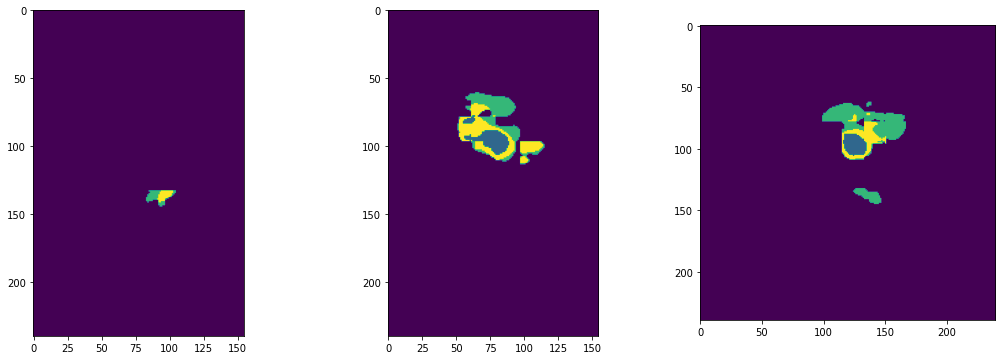

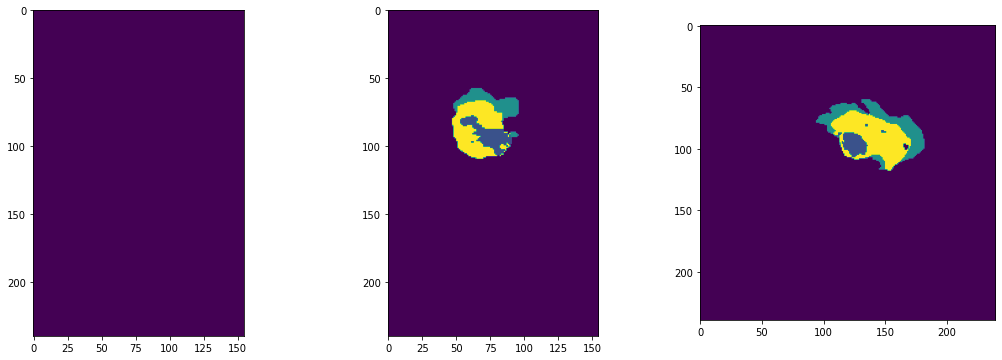

In [47]:
# import nibabel as nib
# param_dict = torch.load(os.path.join(model_dir, f'model_{weights_stem}.pth'), map_location=device)
# model.load_state_dict(param_dict['weights'])
# sample = random.choice(validation_set)
# input_tensor = sample[MRI_t1ce][DATA][0]
# target=sample[LABEL][DATA][0]
# patch_size = 32, 32, 32  # we can user larger or smaller patches for inference
# patch_overlap = 14
# grid_sampler = torchio.inference.GridSampler(
#     sample,
#     patch_size,
#     patch_overlap,
# )
# patch_loader = torch.utils.data.DataLoader(
#     grid_sampler, batch_size=validation_batch_size)
# aggregator = torchio.inference.GridAggregator(grid_sampler)

# model.eval()
# with torch.no_grad():
#     for patches_batch in patch_loader:
#         inputs = patches_batch[MRI][DATA].to(device)
#         locations = patches_batch['location']
#         logits = model(inputs)
#         labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True).long()
#         aggregator.add_batch(labels, locations)
# plot_central_cuts(aggregator.get_output_tensor())
# plot_central_cuts(target)